In [65]:
# Initial imports
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools_fp import MCSimulation
import numpy as np
import datetime
from datetime import date
import logging
import csv
import json


%matplotlib inline

In [66]:
bpip_delta=datetime.timedelta(weeks=1)
bpip_pair_delta=datetime.timedelta(weeks=4)
bpip_delta10=datetime.timedelta(weeks=12)
bpip_delta30=datetime.timedelta(weeks=205)

# ISO 8601 week as number with Monday as the first day of the week then change date from string to int
bpip_date = date.today()
bpip_date_cast = bpip_date + bpip_delta10
bpip_date_hist = bpip_date - bpip_delta30
bpip_day_fdiff = (bpip_date_cast - bpip_date) / 7
bpip_day_hdiff = (bpip_date - bpip_date_hist) / 7
bpip_fdiff = bpip_day_fdiff.days
bpip_hdiff = bpip_day_hdiff.days


In [67]:
#Loop through url calendars for forcast data
count=0
df_ffxevents_list = []
while(count < bpip_fdiff):
    bpip_dfdelta=datetime.timedelta(weeks=count)
    bpip_date_dfcast = bpip_date + bpip_dfdelta
    print(f"Forecast Date: {bpip_date_dfcast}")
    bpip_wk_dfcaststr = bpip_date_dfcast.strftime("%V")
    print(f"Forecast Week String: {bpip_wk_dfcaststr}")
    bpip_yr_dfcaststr = bpip_date_dfcast.strftime("%Y")
    print(f"Current Year String: {bpip_yr_dfcaststr}")
    bpip_yr_dfcastiso = bpip_date_dfcast.isocalendar()[0]
    print(f"Current Year: {bpip_yr_dfcastiso}")
    # get webpage and make the soup
    babe_url = f"https://www.babypips.com/economic-calendar?timezone=America%2FChicago&week={bpip_yr_dfcastiso}-W{bpip_wk_dfcaststr}"
    print(babe_url)
    baseURL = requests.get(babe_url)
    fxcal_soup = BeautifulSoup(baseURL.content, 'html.parser')

    #Get all tag decendents 
    fxcal = fxcal_soup.find(class_="Table-module__table___2Nidf")
    fxcal_tbl_days = fxcal.find_all(class_="Section-module__container___2mwAW")

    #Loop through html classes and div tag elements
    #df_ffxevents_list = []
    for x in fxcal_tbl_days[0:]:
        pd_news_day = [a.get_text() for a in x.select(".Section-module__container___2mwAW .Table-module__name___1XC4z")]
        pd_month_day = [b.get_text() for b in x.select(".Section-module__container___2mwAW .Table-module__month___2Efxb") * len(pd_news_day)]
        pd_date_day = [c.get_text() for c in x.select(".Section-module__container___2mwAW .Table-module__dayNumber___1DiwN") * len(pd_news_day)]
        pd_wkday_day = [d.get_text() for d in x.select(".Section-module__container___2mwAW .Table-module__weekday___1xUx_") * len(pd_news_day)]
        pd_time_day = [e.get_text() for e in x.select(".Section-module__container___2mwAW .Table-module__time___iPjt3")]
        pd_curr_day = [f.get_text() for f in x.select(".Section-module__container___2mwAW .Currency-module__code___1A32e")]
        pd_impact_day = [g.get_text() for g in x.select(".Section-module__container___2mwAW .Impact-module__pill___2pcuA")]
        pd_forecast_day = [h.get_text() for h in x.select(".Table-module__eventRow___2Z1BD .Table-module__forecast___3F_kh")]
        pd_previous_day = [i.get_text() for i in x.select(".Table-module__eventRow___2Z1BD .Table-module__previous___1PJZ9")]

    #Build list elements into list of dataframes, concatenate dataframes and export to csv 
        df_ffxevents_day = pd.DataFrame.from_dict({
        "pd_year": bpip_yr_dfcastiso,
        "pd_month": pd_month_day,
        "pd_date": pd_date_day,
        "pd_weekday": pd_wkday_day,
        "pd_time": pd_time_day,
        "pd_currency": pd_curr_day,
        "pd_news": pd_news_day,
        "pd_impact": pd_impact_day,
        "pd_forecast": pd_forecast_day,
        "pd_previous": pd_previous_day})
        df_ffxevents_list.append(df_ffxevents_day)
    count = count + 1
df_ffxevents_cat = pd.concat(df_ffxevents_list)
df_ffxevents_cat.to_csv('fxevents_forecast.csv')
count=0
df_ffxevents_cat.head(20)


Forecast Date: 2021-01-04
Forecast Week String: 01
Current Year String: 2021
Current Year: 2021
https://www.babypips.com/economic-calendar?timezone=America%2FChicago&week=2021-W01
Forecast Date: 2021-01-11
Forecast Week String: 02
Current Year String: 2021
Current Year: 2021
https://www.babypips.com/economic-calendar?timezone=America%2FChicago&week=2021-W02
Forecast Date: 2021-01-18
Forecast Week String: 03
Current Year String: 2021
Current Year: 2021
https://www.babypips.com/economic-calendar?timezone=America%2FChicago&week=2021-W03
Forecast Date: 2021-01-25
Forecast Week String: 04
Current Year String: 2021
Current Year: 2021
https://www.babypips.com/economic-calendar?timezone=America%2FChicago&week=2021-W04
Forecast Date: 2021-02-01
Forecast Week String: 05
Current Year String: 2021
Current Year: 2021
https://www.babypips.com/economic-calendar?timezone=America%2FChicago&week=2021-W05
Forecast Date: 2021-02-08
Forecast Week String: 06
Current Year String: 2021
Current Year: 2021
http

,pd_year,pd_month,pd_date,pd_weekday,pd_time,pd_currency,pd_news,pd_impact,pd_forecast,pd_previous
0,2021,Jan,3,Sunday,16:00,AUD,AIG Manufacturing Index,med,56.0,55.8
1,2021,Jan,3,Sunday,18:30,JPY,Jibun Bank Manufacturing PMI Final,med,49.7,49.0
2,2021,Jan,3,Sunday,19:45,CNY,Chinese Caixin Manufacturing PMI,high,54.6,54.9
0,2021,Jan,4,Monday,01:00,GBP,Nationwide Housing Prices YoY,med,,
1,2021,Jan,4,Monday,01:00,GBP,Nationwide Housing Prices MoM,med,,
2,2021,Jan,4,Monday,02:30,CHF,procure.ch Manufacturing PMI,low,54.5,55.2
3,2021,Jan,4,Monday,02:50,EUR,French Markit Manufacturing PMI Final,low,51.1,49.6
4,2021,Jan,4,Monday,02:55,EUR,German Markit Manufacturing PMI Final,med,58.6,57.8
5,2021,Jan,4,Monday,03:00,EUR,Markit Manufacturing PMI Final,med,55.5,53.8
6,2021,Jan,4,Monday,03:30,GBP,Markit/CIPS Manufacturing PMI Final,med,57.3,55.6


In [68]:
file_path = Path("fxevents_forecast.csv")
forecast_data = pd.read_csv(file_path)
forecast_data.head(20)

,Unnamed: 0,pd_year,pd_month,pd_date,pd_weekday,pd_time,pd_currency,pd_news,pd_impact,pd_forecast,pd_previous
0,0,2021,Jan,3,Sunday,16:00,AUD,AIG Manufacturing Index,med,56.0,55.8
1,1,2021,Jan,3,Sunday,18:30,JPY,Jibun Bank Manufacturing PMI Final,med,49.7,49.0
2,2,2021,Jan,3,Sunday,19:45,CNY,Chinese Caixin Manufacturing PMI,high,54.6,54.9
3,0,2021,Jan,4,Monday,01:00,GBP,Nationwide Housing Prices YoY,med,NaN,NaN
4,1,2021,Jan,4,Monday,01:00,GBP,Nationwide Housing Prices MoM,med,NaN,NaN
5,2,2021,Jan,4,Monday,02:30,CHF,procure.ch Manufacturing PMI,low,54.5,55.2
6,3,2021,Jan,4,Monday,02:50,EUR,French Markit Manufacturing PMI Final,low,51.1,49.6
7,4,2021,Jan,4,Monday,02:55,EUR,German Markit Manufacturing PMI Final,med,58.6,57.8
8,5,2021,Jan,4,Monday,03:00,EUR,Markit Manufacturing PMI Final,med,55.5,53.8
9,6,2021,Jan,4,Monday,03:30,GBP,Markit/CIPS Manufacturing PMI Final,med,57.3,55.6


In [69]:
forecast_data['Date'] = pd.to_datetime(forecast_data[['pd_month', 'pd_date', 'pd_year']].astype(str).agg('-'.join, axis=1))
forecast_data.set_index(forecast_data['Date'], inplace=True)
forecast_data = forecast_data.drop(columns=["pd_month", "pd_date", "pd_year", "pd_weekday", "Date"])
forecast_data = forecast_data.loc[:, ~forecast_data.columns.str.contains('^Unnamed')]
forecast_data.head(20)

,pd_time,pd_currency,pd_news,pd_impact,pd_forecast,pd_previous
Date,,,,,,
2021-01-03,16:00,AUD,AIG Manufacturing Index,med,56.0,55.8
2021-01-03,18:30,JPY,Jibun Bank Manufacturing PMI Final,med,49.7,49.0
2021-01-03,19:45,CNY,Chinese Caixin Manufacturing PMI,high,54.6,54.9
2021-01-04,01:00,GBP,Nationwide Housing Prices YoY,med,NaN,NaN
2021-01-04,01:00,GBP,Nationwide Housing Prices MoM,med,NaN,NaN
2021-01-04,02:30,CHF,procure.ch Manufacturing PMI,low,54.5,55.2
2021-01-04,02:50,EUR,French Markit Manufacturing PMI Final,low,51.1,49.6
2021-01-04,02:55,EUR,German Markit Manufacturing PMI Final,med,58.6,57.8
2021-01-04,03:00,EUR,Markit Manufacturing PMI Final,med,55.5,53.8


In [70]:
forecast_data = forecast_data[forecast_data['pd_currency'].isin(['USD', 'EUR', 'GBP', 'JPY'])]
forecast_data = forecast_data[forecast_data['pd_impact'].isin(['high'])]
forecast_data.head(20)

,pd_time,pd_currency,pd_news,pd_impact,pd_forecast,pd_previous
Date,,,,,,
2021-01-05,23:00,JPY,Consumer Confidence,high,35.0,33.7
2021-01-06,07:15,USD,ADP National Employment Report,high,170.0k,307.0k
2021-01-07,07:30,USD,Balance of Trade,high,-67.6B,-63.1B
2021-01-08,01:00,EUR,German Balance of Trade,high,17.6B,19.4B
2021-01-08,04:00,EUR,Business Climate,high,NaN,NaN
2021-01-08,07:30,USD,Nonfarm Payrolls,high,112.0k,245.0k
2021-01-08,07:30,USD,Unemployment Rate,high,6.7%,6.7%
2021-01-08,07:30,USD,Average Hourly Earnings MoM,high,0.1%,0.3%
2021-01-13,07:30,USD,Inflation Rate YoY,high,1.2%,1.2%


In [71]:
forecast_data.isnull().mean() * 100

pd_time         0.00
pd_currency     0.00
pd_news         0.00
pd_impact       0.00
pd_forecast    63.75
pd_previous    68.75
dtype: float64

In [72]:
forecast_data["pd_forecast"] = forecast_data["pd_forecast"].fillna(0)
forecast_data["pd_previous"] = forecast_data["pd_previous"].fillna(0)
forecast_data.head(20)

,pd_time,pd_currency,pd_news,pd_impact,pd_forecast,pd_previous
Date,,,,,,
2021-01-05,23:00,JPY,Consumer Confidence,high,35.0,33.7
2021-01-06,07:15,USD,ADP National Employment Report,high,170.0k,307.0k
2021-01-07,07:30,USD,Balance of Trade,high,-67.6B,-63.1B
2021-01-08,01:00,EUR,German Balance of Trade,high,17.6B,19.4B
2021-01-08,04:00,EUR,Business Climate,high,0,0
2021-01-08,07:30,USD,Nonfarm Payrolls,high,112.0k,245.0k
2021-01-08,07:30,USD,Unemployment Rate,high,6.7%,6.7%
2021-01-08,07:30,USD,Average Hourly Earnings MoM,high,0.1%,0.3%
2021-01-13,07:30,USD,Inflation Rate YoY,high,1.2%,1.2%


In [73]:
forecast_data.isnull().mean() * 100

pd_time        0.0
pd_currency    0.0
pd_news        0.0
pd_impact      0.0
pd_forecast    0.0
pd_previous    0.0
dtype: float64

In [74]:
forecast_data = forecast_data.rename(columns={
    "pd_time": "Time",
    "pd_currency": "Currency",
    "pd_news": "News", 
    "pd_impact": "Impact",
    "pd_forecast": "Forecast",
    "pd_previous": "Previous"})
forecast_data.to_csv("Data/fxevents_forecast_GSd.csv")
forecast_data.head(20)

,Time,Currency,News,Impact,Forecast,Previous
Date,,,,,,
2021-01-05,23:00,JPY,Consumer Confidence,high,35.0,33.7
2021-01-06,07:15,USD,ADP National Employment Report,high,170.0k,307.0k
2021-01-07,07:30,USD,Balance of Trade,high,-67.6B,-63.1B
2021-01-08,01:00,EUR,German Balance of Trade,high,17.6B,19.4B
2021-01-08,04:00,EUR,Business Climate,high,0,0
2021-01-08,07:30,USD,Nonfarm Payrolls,high,112.0k,245.0k
2021-01-08,07:30,USD,Unemployment Rate,high,6.7%,6.7%
2021-01-08,07:30,USD,Average Hourly Earnings MoM,high,0.1%,0.3%
2021-01-13,07:30,USD,Inflation Rate YoY,high,1.2%,1.2%


In [75]:
forecast_path = Path("Data/fxevents_forecast_master.csv")
forecastmstr_data = pd.read_csv(forecast_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
forecastmstr_data.head(20)

,Time,Currency,News,Impact,Forecast,Previous,Direction
Date,,,,,,,
2021-01-05,23:00,JPY,Consumer Confidence,high,35,33.7,1
2021-01-06,7:15,USD,ADP National Employment Report,high,170.0k,307.0k,1
2021-01-07,7:30,USD,Balance of Trade,high,-67.6B,-63.1B,1
2021-01-08,1:00,EUR,German Balance of Trade,high,17.6B,19.4B,1
2021-01-08,4:00,EUR,Business Climate,high,0,0,0
2021-01-08,7:30,USD,Nonfarm Payrolls,high,112.0k,245.0k,1
2021-01-08,7:30,USD,Unemployment Rate,high,6.70%,6.70%,-1
2021-01-08,7:30,USD,Average Hourly Earnings MoM,high,0.10%,0.30%,1
2021-01-13,7:30,USD,Inflation Rate YoY,high,1.20%,1.20%,-1


In [76]:
forecastmstr_data["Previous"] = forecastmstr_data["Previous"].str.replace("*", "").str.replace("%", "").str.replace("k", "").str.replace("B", "").str.replace(",", "")
forecastmstr_data["Forecast"] = forecastmstr_data["Forecast"].str.replace("*", "").str.replace("%", "").str.replace("k", "").str.replace("B", "").str.replace(",", "")    
forecastmstr_data['Previous'] = forecastmstr_data['Previous'].astype('float')
forecastmstr_data['Forecast'] = forecastmstr_data['Forecast'].astype('float')
forecastmstr_data.head(20)

,Time,Currency,News,Impact,Forecast,Previous,Direction
Date,,,,,,,
2021-01-05,23:00,JPY,Consumer Confidence,high,35.0,33.7,1
2021-01-06,7:15,USD,ADP National Employment Report,high,170.0,307.0,1
2021-01-07,7:30,USD,Balance of Trade,high,-67.6,-63.1,1
2021-01-08,1:00,EUR,German Balance of Trade,high,17.6,19.4,1
2021-01-08,4:00,EUR,Business Climate,high,0.0,0.0,0
2021-01-08,7:30,USD,Nonfarm Payrolls,high,112.0,245.0,1
2021-01-08,7:30,USD,Unemployment Rate,high,6.7,6.7,-1
2021-01-08,7:30,USD,Average Hourly Earnings MoM,high,0.1,0.3,1
2021-01-13,7:30,USD,Inflation Rate YoY,high,1.2,1.2,-1


In [79]:
def pair_menu():
    print("[1] USD/JPY")
    print("[2] EUR/USD")
    print("[3] GBP/USD")
    print("[4] EXIT")

def get_pair_con(target_pair, base, quote):
    print(f"Retrieving 4-week forecast of high impact announcements for {target_pair}...\n")
    # Get 4-week forecast for currency pair
    bpip_pair_cast = bpip_date + bpip_pair_delta
    forecastmstr_filter = forecastmstr_data.loc[bpip_date:bpip_pair_cast]
    forecastmstr_filter_pair = forecastmstr_filter[forecastmstr_filter['Currency'].isin([base, quote])]
    print(forecastmstr_filter_pair)
    
    # Get consensus for base currency - Positive Key
    forecastmstr_filter_base = forecastmstr_filter[forecastmstr_filter['Currency'].isin([base])]
    pos_base_filter = forecastmstr_filter_base.loc[forecastmstr_filter_base['Direction'] == 1]
    base_pos_forcnt1 = sum(pos_base_filter.Forecast > pos_base_filter.Previous) #(default) sum of comparison to determining if news is positive for base currency
    base_neg_forcnt1 = sum(pos_base_filter.Forecast < pos_base_filter.Previous) #sum of comparison to determining if news is negative for base currency
    
    # Get consensus for quoted currency - Positive Key
    forecastmstr_filter_quote = forecastmstr_filter[forecastmstr_filter['Currency'].isin([quote])]
    pos_quote_filter = forecastmstr_filter_quote.loc[forecastmstr_filter_quote['Direction'] == 1]
    quote_pos_forcnt1 = sum(pos_quote_filter.Forecast > pos_quote_filter.Previous) #(default) sum of comparison to determining if news is positive for quote currency
    quote_neg_forcnt1 = sum(pos_quote_filter.Forecast < pos_quote_filter.Previous) #sum of comparison to determining if news is negative for quote currency
   
    # -----------------------------------------------------------------------

    # Get consensus for base currency - Negative Key
    forecastmstr_filter_base = forecastmstr_filter[forecastmstr_filter['Currency'].isin([base])]
    neg_base_filter = forecastmstr_filter_base.loc[forecastmstr_filter_base['Direction'] == -1]
    base_pos_forcnt = sum(neg_base_filter.Forecast > neg_base_filter.Previous) #(default) sum of comparison to determining if news is positive for base currency
    base_neg_forcnt = sum(neg_base_filter.Forecast < neg_base_filter.Previous) #sum of comparison to determining if news is negative for base currency
    
    # Get consensus for quoted currency - Negative Key
    forecastmstr_filter_quote = forecastmstr_filter[forecastmstr_filter['Currency'].isin([quote])]
    neg_quote_filter = forecastmstr_filter_quote.loc[forecastmstr_filter_quote['Direction'] == -1]
    quote_pos_forcnt = sum(neg_quote_filter.Forecast > neg_quote_filter.Previous) #(default) sum of comparison to determining if news is positive for quote currency
    quote_neg_forcnt = sum(neg_quote_filter.Forecast < neg_quote_filter.Previous) #sum of comparison to determining if news is negative for quote currency

    #Total the number of positive vs. negative consensus for the base and quoted currency 
    tot_base_pos_sum = base_pos_forcnt1+base_pos_forcnt
    tot_base_neg_sum = base_neg_forcnt1+base_neg_forcnt
    tot_quote_pos_sum = quote_pos_forcnt1+quote_pos_forcnt
    tot_quote_neg_sum = quote_neg_forcnt1+quote_neg_forcnt
    
    #Compare the number of positive vs. negative consensus for the base and quoted currency and give recommendation
    if (tot_base_neg_sum > tot_base_pos_sum) and (tot_quote_pos_sum > tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall negative for the {base} and"
              f" positive for the {quote} therefore the recommendation is to sell the {base}/{quote}")
    elif (tot_base_neg_sum < tot_base_pos_sum) and (tot_quote_pos_sum < tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall positive for the {base} and negative for"
              f" the {quote} therefore the recommendation is to buy {base}/{quote}")
    elif (tot_base_neg_sum > tot_base_pos_sum) and (tot_quote_pos_sum < tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall neutral for the {base}/{quote}. Trade at"
              f" your own discretion")
    elif (tot_base_neg_sum < tot_base_pos_sum) and (tot_quote_pos_sum > tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall neutral for the {base}/{quote}. Trade at"
              f" your own discretion")
    elif (tot_base_neg_sum == tot_base_pos_sum) and (tot_quote_pos_sum < tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall positive for the {base} and negative for"
              f" the {quote} therefore the recommendation is to buy {base}/{quote}")
    elif (tot_base_neg_sum < tot_base_pos_sum) and (tot_quote_pos_sum == tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall positive for the {base} and negative for"
              f" the {quote} therefore the recommendation is to buy {base}/{quote}")
    elif (tot_base_neg_sum == tot_base_pos_sum) and (tot_quote_pos_sum > tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall negative for the {base} and positive for"
              f" the {quote} therefore the recommendation is to sell the {base}/{quote}")
    elif (tot_base_neg_sum > tot_base_pos_sum) and (tot_quote_pos_sum == tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall negative for the {base} and positive for"
              f" the {quote} therefore the recommendation is to sell the {base}/{quote}")
    elif (tot_base_neg_sum == tot_base_pos_sum) and (tot_quote_pos_sum == tot_quote_neg_sum):
        print(f"The consensus for the next 4 weeks is overall neutral for the {base}/{quote}. Trade at"
              f" your own discretion")

pair_menu()
pair_option = int(input("Select the currency pair you wish to trade: "))

while pair_option != 4:
    if pair_option == 1:
        #get USDJPY news events & provide recommendation
        get_pair_con('USD/JPY', 'USD', 'JPY')
    elif pair_option == 2:
        #get EURUSD news events & provide recommendation
        get_pair_con('EUR/USD', 'EUR', 'USD')
    elif pair_option == 3:
        #get GBPUSD news events & provide recommendation
        get_pair_con('GBP/USD', 'GBP', 'USD')
    else:
        print(f"Invalid selection. please choose a valid option ")

    print()
    pair_menu()
    pair_option = int(input("Select the currency pair you wish to trade: "))

print(f"Thanks for using the FOREX Robo Advisor. Happy Trading!!")

[1] USD/JPY
[2] EUR/USD
[3] GBP/USD
[4] EXIT


Select the currency pair you wish to trade:  1


Retrieving 4-week forecast of high impact announcements for USD/JPY...

             Time Currency                            News Impact  Forecast  \
Date                                                                          
2021-01-05  23:00      JPY             Consumer Confidence   high      35.0   
2021-01-06   7:15      USD  ADP National Employment Report   high     170.0   
2021-01-07   7:30      USD                Balance of Trade   high     -67.6   
2021-01-08   7:30      USD                Nonfarm Payrolls   high     112.0   
2021-01-08   7:30      USD               Unemployment Rate   high       6.7   
2021-01-08   7:30      USD     Average Hourly Earnings MoM   high       0.1   
2021-01-13   7:30      USD              Inflation Rate YoY   high       1.2   
2021-01-13   7:30      USD         Core Inflation Rate YoY   high       1.6   
2021-01-15   7:30      USD                         PPI MoM   high       0.2   
2021-01-15   7:30      USD                Retail Sales MoM 

Select the currency pair you wish to trade:  2


Retrieving 4-week forecast of high impact announcements for EUR/USD...

            Time Currency                            News Impact  Forecast  \
Date                                                                         
2021-01-06  7:15      USD  ADP National Employment Report   high     170.0   
2021-01-07  7:30      USD                Balance of Trade   high     -67.6   
2021-01-08  1:00      EUR         German Balance of Trade   high      17.6   
2021-01-08  4:00      EUR                Business Climate   high       0.0   
2021-01-08  7:30      USD                Nonfarm Payrolls   high     112.0   
2021-01-08  7:30      USD               Unemployment Rate   high       6.7   
2021-01-08  7:30      USD     Average Hourly Earnings MoM   high       0.1   
2021-01-13  7:30      USD              Inflation Rate YoY   high       1.2   
2021-01-13  7:30      USD         Core Inflation Rate YoY   high       1.6   
2021-01-14  3:00      EUR        German Government Budget   high      

Select the currency pair you wish to trade:  1


Retrieving 4-week forecast of high impact announcements for USD/JPY...

             Time Currency                            News Impact  Forecast  \
Date                                                                          
2021-01-05  23:00      JPY             Consumer Confidence   high      35.0   
2021-01-06   7:15      USD  ADP National Employment Report   high     170.0   
2021-01-07   7:30      USD                Balance of Trade   high     -67.6   
2021-01-08   7:30      USD                Nonfarm Payrolls   high     112.0   
2021-01-08   7:30      USD               Unemployment Rate   high       6.7   
2021-01-08   7:30      USD     Average Hourly Earnings MoM   high       0.1   
2021-01-13   7:30      USD              Inflation Rate YoY   high       1.2   
2021-01-13   7:30      USD         Core Inflation Rate YoY   high       1.6   
2021-01-15   7:30      USD                         PPI MoM   high       0.2   
2021-01-15   7:30      USD                Retail Sales MoM 

Select the currency pair you wish to trade:  2


Retrieving 4-week forecast of high impact announcements for EUR/USD...

            Time Currency                            News Impact  Forecast  \
Date                                                                         
2021-01-06  7:15      USD  ADP National Employment Report   high     170.0   
2021-01-07  7:30      USD                Balance of Trade   high     -67.6   
2021-01-08  1:00      EUR         German Balance of Trade   high      17.6   
2021-01-08  4:00      EUR                Business Climate   high       0.0   
2021-01-08  7:30      USD                Nonfarm Payrolls   high     112.0   
2021-01-08  7:30      USD               Unemployment Rate   high       6.7   
2021-01-08  7:30      USD     Average Hourly Earnings MoM   high       0.1   
2021-01-13  7:30      USD              Inflation Rate YoY   high       1.2   
2021-01-13  7:30      USD         Core Inflation Rate YoY   high       1.6   
2021-01-14  3:00      EUR        German Government Budget   high      

Select the currency pair you wish to trade:  3


Retrieving 4-week forecast of high impact announcements for GBP/USD...

             Time Currency                            News Impact  Forecast  \
Date                                                                          
2021-01-06   7:15      USD  ADP National Employment Report   high     170.0   
2021-01-07   7:30      USD                Balance of Trade   high     -67.6   
2021-01-08   7:30      USD                Nonfarm Payrolls   high     112.0   
2021-01-08   7:30      USD               Unemployment Rate   high       6.7   
2021-01-08   7:30      USD     Average Hourly Earnings MoM   high       0.1   
2021-01-13   7:30      USD              Inflation Rate YoY   high       1.2   
2021-01-13   7:30      USD         Core Inflation Rate YoY   high       1.6   
2021-01-15   1:00      GBP    Manufacturing Production MoM   high       0.2   
2021-01-15   1:00      GBP    Manufacturing Production YoY   high      -6.0   
2021-01-15   1:00      GBP                Balance of Trade 

Select the currency pair you wish to trade:  4


Thanks for using the FOREX Robo Advisor. Happy Trading!!


In [80]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [81]:
# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes between now and 5 years ago.
start_date = pd.Timestamp("2016-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-01-04", tz="America/New_York").isoformat()

# Set the ticker information
symbols = ["FXE","FXY","FXG"]

# Get 5 year's worth of historical price data
df_symbols = api.get_barset(
    symbols,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_symbols.head()

FXE                                         \
                             open      high       low   close     volume   
time                                                                       
2016-01-04 00:00:00-05:00  106.21  106.3000  105.5400  106.00   724119.0   
2016-01-05 00:00:00-05:00  105.23  105.2699  104.8501  105.24  1000890.0   
2016-01-06 00:00:00-05:00  105.12  105.7166  105.1200  105.60   781611.0   
2016-01-07 00:00:00-05:00  106.26  107.0800  105.9750  107.02  1174544.0   
2016-01-08 00:00:00-05:00  106.42  106.9000  106.2400  106.88   942700.0   

                             FXG                                   FXY         \
                            open     high    low  close  volume   open   high   
time                                                                            
2016-01-04 00:00:00-05:00  43.90  43.9500  43.48  43.95  719571  81.30  81.41   
2016-01-05 00:00:00-05:00  44.00  44.1797  43.82  44.12  399253  81.33  81.50   
2016-01-06 00:00:00-05:00  43.67  44.0790  43.66  43.87  196154  81.65  81.87   
2016-01-07 00:00:00-05:00  43.35  43.7599  43.17  43.33  402814  82.18  82.50   
2016-01-08 00:00:00-05:00  43.58  43.6720  43.12  43.20  369256  82.07  82.49   

                                                    
                              low    close  volume  
time                                                
2016-01-04 00:00:00-05:00  81.090  81.1000  126852  
2016-01-05 00:00:00-05:00  81.240  81.3600  139154  
2016-01-06 00:00:00-05:00  81.560  81.7852  274396  
2016-01-07 00:00:00-05:00  81.970  82.4300  164415  
2016-01-08 00:00:00-05:00  81.955  82.4400  226417

In [82]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_symbols,
    weights = [.33,.33,.33],
    num_simulation = 500,
    num_trading_days = 40*31
)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

FXE                                         \
                             open      high       low   close     volume   
time                                                                       
2016-01-04 00:00:00-05:00  106.21  106.3000  105.5400  106.00   724119.0   
2016-01-05 00:00:00-05:00  105.23  105.2699  104.8501  105.24  1000890.0   
2016-01-06 00:00:00-05:00  105.12  105.7166  105.1200  105.60   781611.0   
2016-01-07 00:00:00-05:00  106.26  107.0800  105.9750  107.02  1174544.0   
2016-01-08 00:00:00-05:00  106.42  106.9000  106.2400  106.88   942700.0   

                                          FXG                                 \
                          daily_return   open     high    low  close  volume   
time                                                                           
2016-01-04 00:00:00-05:00          NaN  43.90  43.9500  43.48  43.95  719571   
2016-01-05 00:00:00-05:00    -0.007170  44.00  44.1797  43.82  44.12  399253   
2016-01-06 00:00:00-05:00     0.003421  43.67  44.0790  43.66  43.87  196154   
2016-01-07 00:00:00-05:00     0.013447  43.35  43.7599  43.17  43.33  402814   
2016-01-08 00:00:00-05:00    -0.001308  43.58  43.6720  43.12  43.20  369256   

                                          FXY                                  \
                          daily_return   open   high     low    close  volume   
time                                                                            
2016-01-04 00:00:00-05:00          NaN  81.30  81.41  81.090  81.1000  126852   
2016-01-05 00:00:00-05:00     0.003868  81.33  81.50  81.240  81.3600  139154   
2016-01-06 00:00:00-05:00    -0.005666  81.65  81.87  81.560  81.7852  274396   
2016-01-07 00:00:00-05:00    -0.012309  82.18  82.50  81.970  82.4300  164415   
2016-01-08 00:00:00-05:00    -0.003000  82.07  82.49  81.955  82.4400  226417   

                                        
                          daily_return  
time                                    
2016-01-04 00:00:00-05:00          NaN  
2016-01-05 00:00:00-05:00     0.003206  
2016-01-06 00:00:00-05:00     0.005226  
2016-01-07 00:00:00-05:00     0.007884  
2016-01-08 00:00:00-05:00     0.000121

In [84]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
print(f"Please standby as the 5 year historical prices for USD/JPY, EUR/USD and GBP/USD are analyzed"
      f" to assess potential returns...")
MC_even_dist.calc_cumulative_return()

Please standby as the 5 year historical prices for USD/JPY, EUR/USD and GBP/USD are analyzed to assess potential returns...
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulat

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002869,1.004272,0.988372,1.000685,0.987861,1.006272,1.000616,1.002451,0.996671,1.000715,...,1.000827,0.999558,1.003211,1.004218,1.007910,0.995528,0.997646,1.001065,1.001186,0.998811
2,1.008649,1.004371,0.987866,0.999002,0.988416,1.007087,1.002074,1.000092,0.995833,0.997754,...,1.000273,1.002678,0.999954,1.000271,1.008072,0.994656,1.001310,1.002857,0.997553,0.994947
3,1.011443,1.011750,0.979113,0.991648,0.992657,1.015126,0.998230,0.999590,0.995715,0.998211,...,0.996564,0.995026,1.002942,0.996213,1.004587,0.994769,1.002056,1.000861,1.000497,0.999146
4,1.018652,1.011875,0.978667,0.984008,0.988458,1.017372,0.996391,1.006716,0.990101,1.010507,...,0.994360,0.992501,1.001749,0.989094,0.996955,0.994638,1.001264,1.007327,0.999580,1.004174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,1.032536,0.983866,1.066257,0.938167,0.885738,1.202286,1.129752,1.258674,1.215056,1.243388,...,1.168207,1.346076,0.927384,1.243255,1.058579,0.806076,0.975183,1.340723,0.858406,1.345872
1237,1.036917,0.992674,1.064888,0.937437,0.882948,1.202408,1.132143,1.258761,1.215036,1.247126,...,1.161292,1.337469,0.925263,1.246578,1.059586,0.804935,0.969489,1.343696,0.858292,1.351446
1238,1.036486,0.990160,1.069611,0.939668,0.889381,1.210963,1.135973,1.260917,1.211669,1.245193,...,1.158515,1.344141,0.923514,1.244015,1.050713,0.802966,0.974951,1.341192,0.858248,1.356694
1239,1.038815,0.991362,1.064353,0.938195,0.889126,1.205149,1.139671,1.264940,1.216466,1.243586,...,1.161414,1.350028,0.921767,1.238033,1.055732,0.802200,0.967941,1.332513,0.856462,1.359980


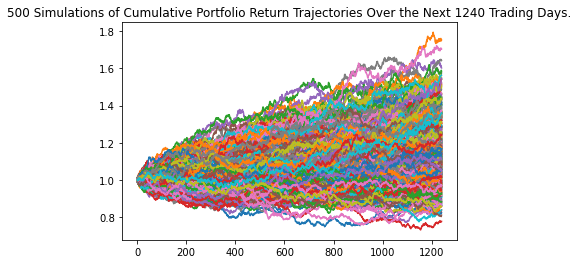

In [85]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

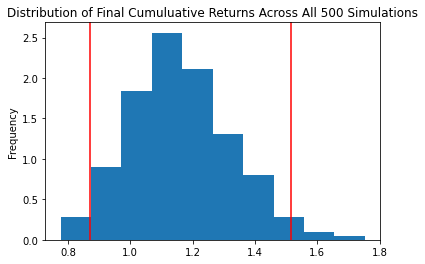

In [86]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

In [87]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = MC_even_dist.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean              1.162029
std               0.164901
min               0.776290
25%               1.045530
50%               1.148945
75%               1.263275
max               1.752870
95% CI Lower      0.871585
95% CI Upper      1.516258
Name: 1240, dtype: float64


In [88]:
# Set initial investment
initial_investment = 10000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower = round(even_tbl[8]*initial_investment,2)
ci_upper = round(even_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} and holding period of every"
      f" 40 days over the next 5 years will end within the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10000 and holding period of every 40 days over the next 5 years will end within the range of $8715.85 and $15162.58
